# Final Tutorial: Analysis of Esports Earnings Across Different Games

Kevin Liang, Kevin Lopoi, Jordan Marry

## Introduction: eSports 

Over the last decade, the the gaming industry has become more and more popular. This large influx in popularity resulted in a boom in the competitve gaming scene, known as eSports. eSports is defined as a form of organized sport competition which involves video games, and is typically between professional players in an individual or a team setting.

While compeitions have always been popular in gaming culture, there wasn't particularly a "professional scene" for video games. Until the late 2000s, competitions have been mostly among amateurs. As more and more people began playing video games and video games become more popularized in our everyday life, viewers for tournaments and video game content in general began increasing as well. However, by the 2010s, eSports have become a "signficiant factor" in the video game industry as companies began to follow a "franchise approach" used in North American sports where there are financial sponsors looking to support teams.

Even to this day, eSports viewership has continued to increase as monthly eSports viewers have increased by 11.4% from 2020. The integration to popular culture and utilization of media outlets all contribute to this growth, and eSports organizations have produced many competitive organizers not only filled with players, but also influencers.
From 2017 to 2018, investments in the industry have skyrocketed from \\$490 million all the way to \\$4.5 billion. These investments are distributed across teams and players across many different games. Projections for this year has the industry on track to "surpass 1 billion dollars in revenue and hit 1.8 billion by 2022 according to Newzoo.
Read more about the growing revenue stream here: 
https://www.insiderintelligence.com/insights/esports-ecosystem-market-report/
This large amount of money does include sponsorships, advertisements, on top of tournament earnings itself. 

This dataset will look at tournament earnings alone, across 10 of the most popular games in the past decade:
Dota2, Counter-Strike: Global Offensive, Fortnite, League of Legends, Starcraft II, Overwatch, PUBG, Hearthstone, Heroes of the Storm, Arena of Valor

If you are curious and want to know more about the eSports industry, you can find out more at: 
https://en.wikipedia.org/wiki/Esports

## Purpose

This tutorial will involve utilizing techniques utilized in data science to analyze a data set that was scraped off https://www.esportsearnings.com, a website that tracks earnings by teams, organizations, and players across all the competitive games. We will be focusing on players and their earnings throughout the years and analyze the results to hope to see trends in how much players earned throughout the years. 

In [2]:
import pandas as pd
import re
import numpy as np
import requests

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup

In [4]:
# Grabbing data from 2010 till now

years = ["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]
dfs = []


session = requests.Session()
retry = Retry(connect=10, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

# Grabbing all the top 100 players from 2010-2021
for i in years:
    # players
    url = "https://www.esportsearnings.com/history/" + i + "/top_players"
    page = session.get(url)
    root = BeautifulSoup(page.content)
    root.prettify()
    table = root.find("table")
    
    rows = table.findAll('tr')
    headers = rows[0].findAll('td')
    headers = headers[1:]
    cols = []
    for head in headers:
        cols.append(head.text.strip())
    
    cols.insert(0, "Rank")
    cols.insert(1, "Year")
    cols.insert(2, "Country")
    cols[3] = "In-Game Name"
    cols.append("Game")
    cols.append("# of Tournaments")
    cols.remove("% of Total")
    
    players = rows[1:]
    
    rank = []
    country = []
    ign = []
    player_name = []
    total_year = []
    total_overall = []
    games = []
    tournaments = []
    
    for player in players:
        infos = player.findAll('td')
        rank.append(infos[0].text.strip())
        country.append(infos[1].find('img').get('title'))
        ign.append(infos[1].text.strip())
        player_name.append(infos[2].text.strip())
        total_year.append(infos[3].text.strip())
        total_overall.append(infos[4].text.strip())
        links = infos[1].findAll('a')
        url2 = "https://www.esportsearnings.com/" + links[1].get('href')
        page = session.get(url2)
        root = BeautifulSoup(page.content)
        title = root.find("h1")
        title = title.text.strip()
        games.append(title)
        
        #tourney = root.findAll('div', {'class' : 'format_cell info_text_value'})
        
        tourney = root.find_all(text=re.compile(' From ' + r'[0-9]+' + ' Tournament'))
        stri = tourney[0].split()
        tournaments.append(stri[1])
        
        
        
    
    df = pd.DataFrame(columns = cols)
    df['Rank'] = rank
    df['Year'] = i
    df['Country'] = country
    df['In-Game Name'] = ign
    df['Player Name'] = player_name
    df['Total (Year)'] = total_year
    df['Total (Overall)'] = total_overall
    df['Game'] = games
    df['# of Tournaments'] = tournaments
    
    dfs.append(df)
    


In [5]:
df = pd.concat(dfs)

# Commenting out so data isn't written over
# df.to_csv('players.csv')

In [6]:
df = pd.read_csv('players.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
games = df['Game'].str.split("- ")
df['Game'] = games

In [8]:
df = df.astype({"Rank": int})

In [9]:
for i in range(0,len(df)):
    df.at[i,'Game'] = df.loc[:, "Game"][i][-1]

In [10]:
df['Game'] = df['Game'].str.replace(" Player","")
df = df.rename(columns={"In-Game Name": "IGN", "Total (Year)": "Total_Year", "Total (Overall)" : "Total_Overall", "# of Tournaments" : "Num_Tournaments"})
df

,Rank,Year,Country,IGN,Player Name,Total_Year,Total_Overall,Game,Num_Tournaments
0,1,2010,"Korea, Republic of",Flash,"Lee, Young Ho","$194,924.30","$670,457.77",StarCraft: Brood War,97
1,2,2010,United States,Mystik,Katherine Gunn,"$100,000.00","$122,550.00",Female Call of Duty,7
2,3,2010,United States,applesauce,Mark Smith,"$100,000.00","$100,000.00",Multigaming,1
3,4,2010,"Korea, Republic of",Jaedong,"Lee, Jae Dong","$98,019.82","$643,290.35",StarCraft: Brood War,111
4,5,2010,"Korea, Republic of",FruitDealer,"Kim, Won Ki","$92,393.59","$103,075.12",StarCraft II,13
...,...,...,...,...,...,...,...,...,...
1195,96,2021,China,coolboy,"Zeng, Ronghua","$213,286.23","$440,728.58",PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,9
1196,97,2021,"Taiwan, Republic of China",Jimmy,"Xu, Yinjun","$213,286.23","$440,728.58",PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,9
1197,98,2021,"Taiwan, Republic of China",King,"Lin, Yien","$213,286.23","$383,202.47",PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,6
1198,99,2021,Israel,Fly,Tal Aizik,"$211,680.00","$2,610,250.81",Dota 2,123


## Explanatory Data Analysis

We have our data that we scraped and put into the dataframe. Now we have to do some digging and play around with it in order to get a better understanding of our data. This is known as Exploratory Data Analysis, which is known as the process of performing initial investigations on the data we have in order to look for patterns, gather insights, and test our hypotheses if we have any.

We have our dataframe and it is cleaned. It currently contains around 1200 entries of top 100 earning competitive players across the years 2010 to 2021. Currently we have columns as Rank, Year, Country, In-Game Name, Player Name, Total(Year), Total(Overall), Game, and # of Tournaments. 

Out of curiousity lets take a look at the top earning players in the past decade. We can use sort values with the column that we are interested in sorting by. We will call this top_Earners.


In [11]:
top_Earners = df.sort_values(by="Total_Overall", ascending=False, ignore_index = True)
#Only use the columns we care about. We can also use top_Earners.drop to achieve similar results
top_Earners = top_Earners[["Player Name", "IGN", "Total_Overall", "Game"]].head(10)
top_Earners

,Player Name,IGN,Total_Overall,Game
0,Hayden Krueger,Elevate,"$993,523.20",VALORANT
1,Jacky Mao,EternaLEnVy,"$992,222.69",Dota 2
2,Jacky Mao,EternaLEnVy,"$992,222.69",Dota 2
3,Jacky Mao,EternaLEnVy,"$992,222.69",Dota 2
4,"Du, Peng",Monet,"$991,422.61",Dota 2
5,Mike Peterson,Wickd,"$99,208.88",League of Legends
6,Johan Åström,pieliedie,"$989,390.86",Dota 2
7,Johan Åström,pieliedie,"$989,390.86",Dota 2
8,Johan Åström,pieliedie,"$989,390.86",Dota 2
9,Kuku Palad,KuKU,"$982,344.63",Dota 2


Above, we can see how the the top earning players. 
### Wait ... this doesn't seem right.
The problem was that the Total (Overall) column is not a float, our numbers are sorted, but not sorted by the value itself. 98000$ might seem like quite a bit, but its no where near the top earners. 
Therefore, lets change that in our original data frame and then rerun the same code. 

In [12]:
#We have to replace some characters in the string in order to be able to convert it to a float.
df['Total_Year'] = df['Total_Year'].str.replace("$","")
df['Total_Year'] = df['Total_Year'].str.replace(",","")
df['Total_Overall'] = df['Total_Overall'].str.replace("$","")
df['Total_Overall'] = df['Total_Overall'].str.replace(",","")
#Converting the column values to all floats
df['Total_Year'] = df['Total_Year'].astype(float)
df['Total_Overall'] = df['Total_Overall'].astype(float)

#Now we can run that same code again and see the results

top_Earners = df.sort_values(by="Total_Overall", ascending=False, ignore_index = True)
#Only use the columns we care about. We can also use top_Earners.drop to achieve similar results
top_Earners = top_Earners[["Player Name", "IGN", "Total_Overall", "Game"]]
top_Earners = top_Earners.drop_duplicates('Player Name')
top_Earners.head()

C:\Users\Jordan\AppData\Local\Temp/ipykernel_16208/1533425610.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Total_Year'] = df['Total_Year'].str.replace("$","")
C:\Users\Jordan\AppData\Local\Temp/ipykernel_16208/1533425610.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Total_Overall'] = df['Total_Overall'].str.replace("$","")


,Player Name,IGN,Total_Overall,Game
0,Johan Sundstein,N0tail,7183917.80,Dota 2
7,Jesse Vainikka,JerAx,6470548.78,VALORANT
11,Anathan Pham,ana,6004411.96,Dota 2
15,Sébastien Debs,Ceb,5773812.41,Dota 2
18,Topias Taavitsainen,Topson,5690417.57,Dota 2



That looks much better. We also had to remove the duplicates based on name, since this dataset includes entries from the years 2010 to 2021. From this we can clearly see that out of our entries, player Clement Ivanov/Puppey has made the most overall in the past 10 years from tournament winnings alone. At around $3,607,594.23, his earnings double the second place earner, who has earned $1,769,541.96.

It seems that the top 5 earning players are all from Dota 2. 

While it seems that Dota 2 may produce the top earning players, lets compare the earnings from each game to see what type of game is the most earning at the moment.

In [13]:
games = top_Earners.groupby('Game').sum().sort_values(by = "Total_Overall", ascending = False)
games

,Total_Overall
Game,
Dota 2,2.340292e+08
CS:GO,5.338700e+07
League of Legends,2.977330e+07
Fortnite,2.677205e+07
Call of Duty,2.535829e+07
StarCraft II,1.761912e+07
Arena of Valor,1.415667e+07
VALORANT,1.396358e+07
PUBG,6.914846e+06


#### To visualize this better, lets graph this. 
Visualizing data is a big part of exploratory data analysis. Therefore lets make a graph to see the top earning games. We can also extend this further to see the trends in games across the years, by graphing the earnings of each game by year. 
The first graph shows the top earnings from 2010 - 2021, with salaries from every player, every year all combined together grouped by games. The Y axis will show earnings in millions. 

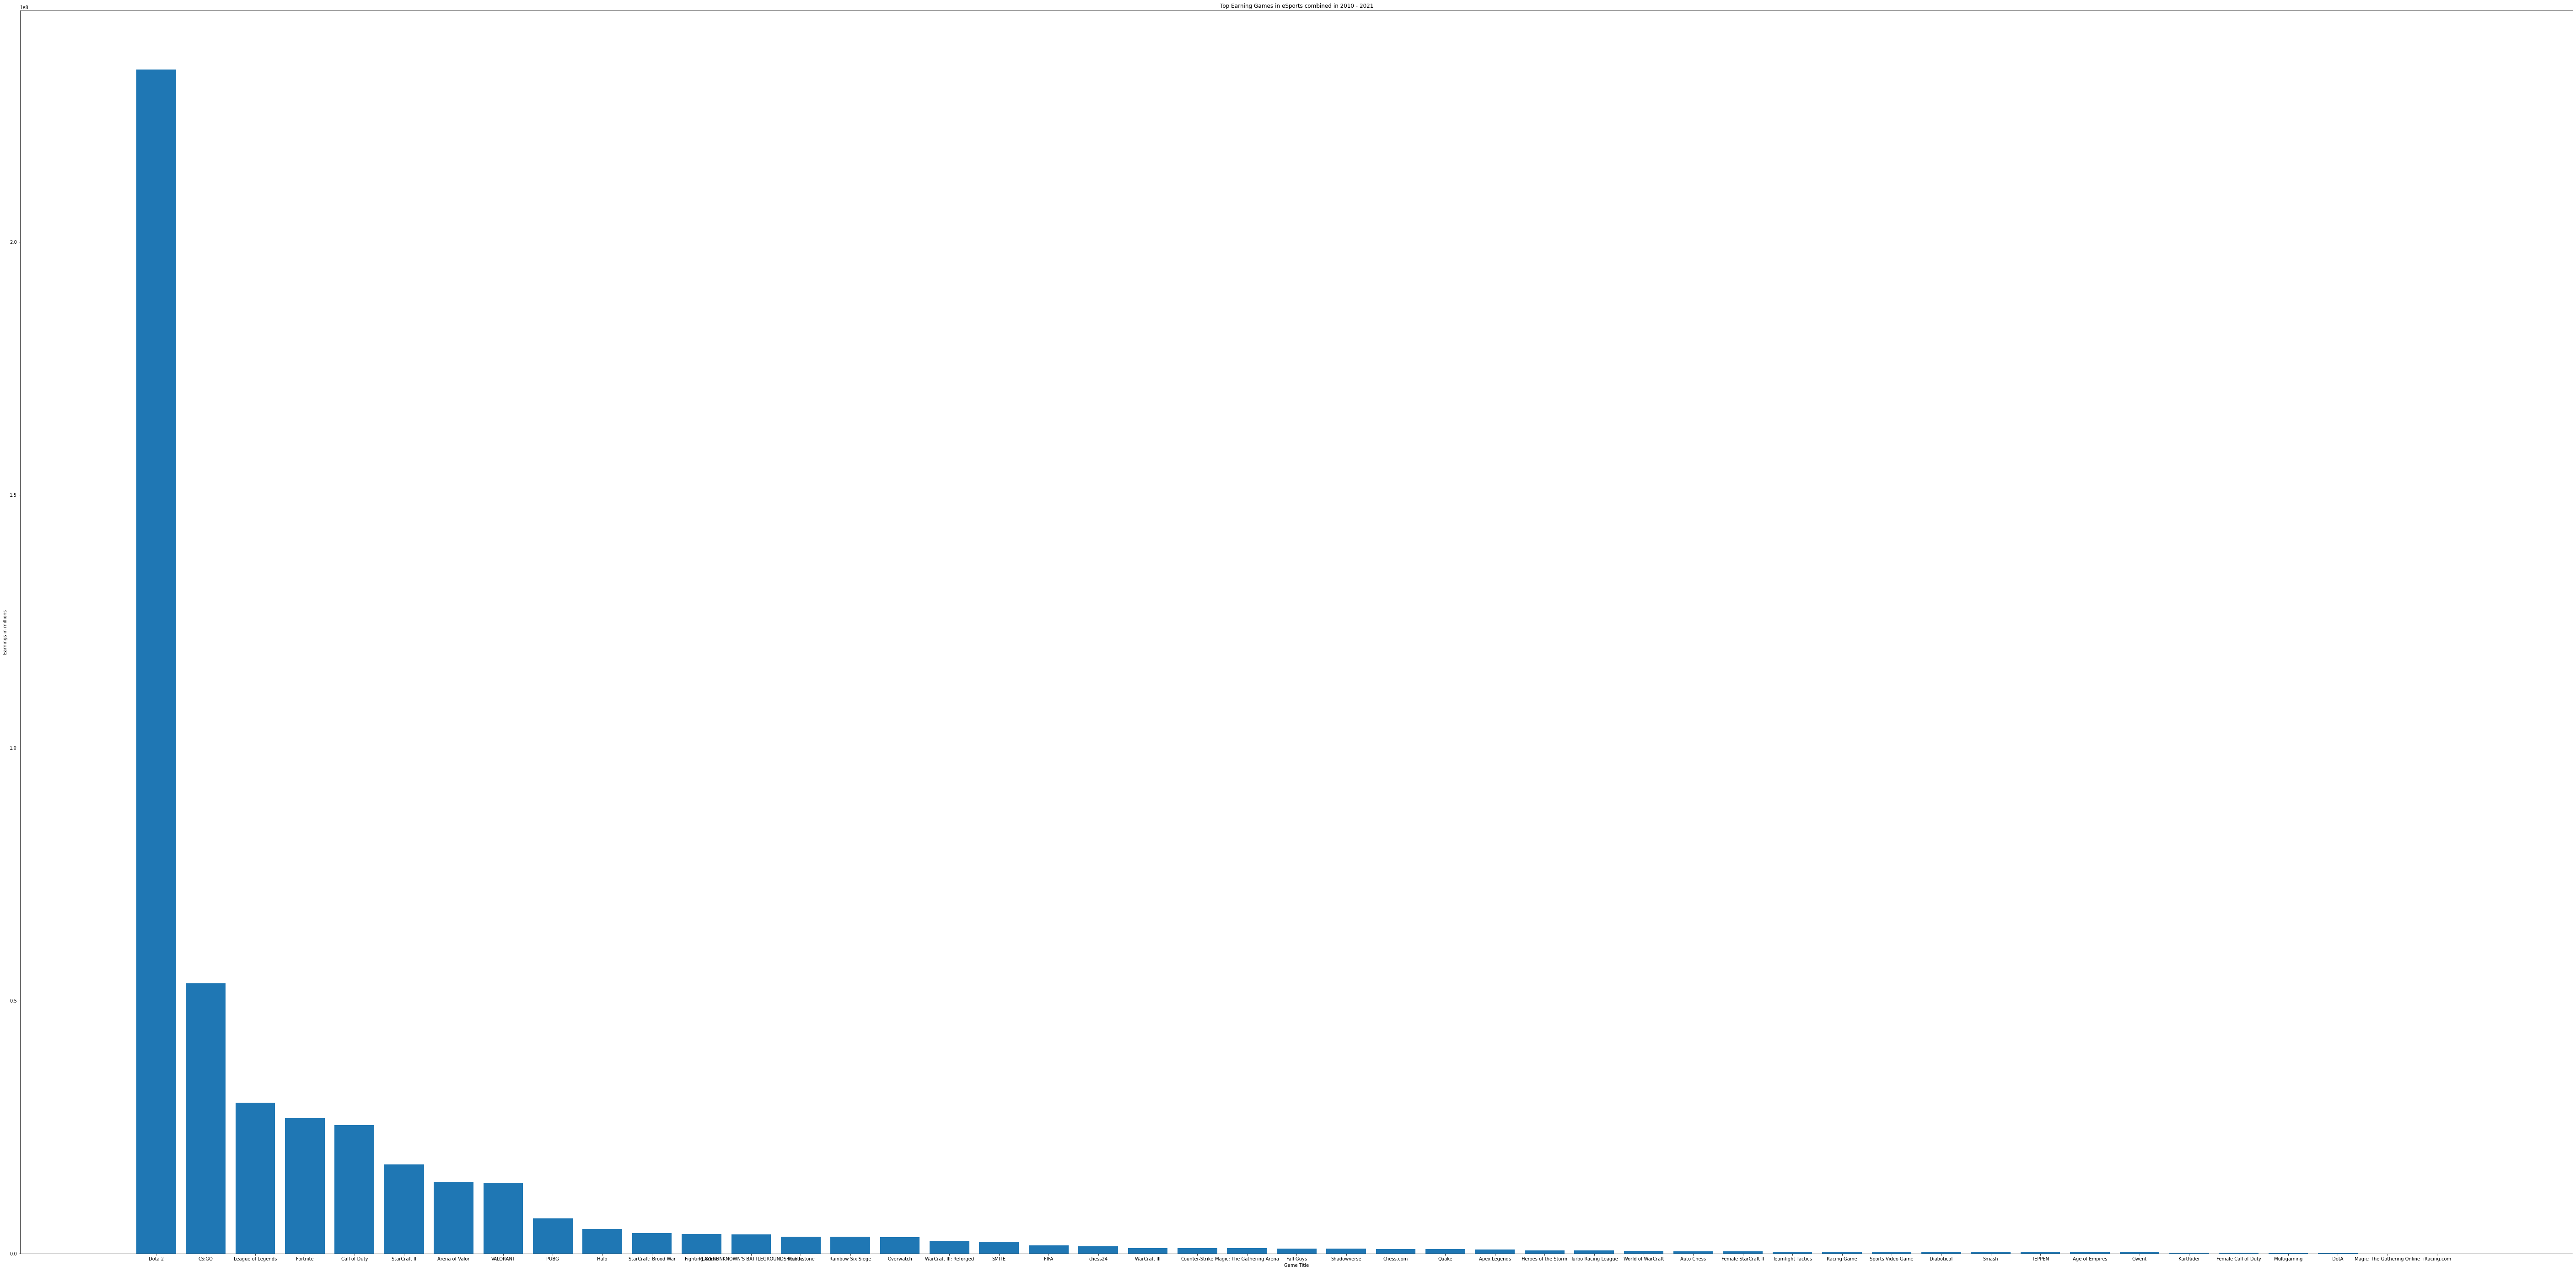

In [14]:
#we are gonna need this import
import matplotlib.pyplot as plt

plt.figure(figsize = (100,50))
plt.title("Top Earning Games in eSports combined in 2010 - 2021")
plt.xlabel("Game Title")
plt.ylabel("Earnings in millions")
plt.bar(games.index, games['Total_Overall'])

plt.rc('axes', titlesize=20)
plt.show()

In [15]:
game_titles = np.unique(df['Game'])
years = np.arange(2010,2021)
years_table = pd.DataFrame(columns = ['Year'], data = years)
#Making a copy here. May be a good idea once in a while to do so if you are consistently working with one dataframe.
#On the notebook, if you rerun the same codeblock after modifying the dataframe, you make run into some errors so you 
#would have to run everything again.
df1 = df.copy()
df1 = df1[['Year', 'Game', 'Total_Year']]
df1 = df1.groupby(['Year', 'Game']).sum()
df1.reset_index(inplace= True)
df1

,Year,Game,Total_Year
0,2010,CS:GO,376229.40
1,2010,Counter-Strike,184425.49
2,2010,FIFA,20000.00
3,2010,Female Call of Duty,100000.00
4,2010,Fighting Game,25850.00
...,...,...,...
161,2021,Fortnite,216023.54
162,2021,PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,1097691.15
163,2021,PUBG,3412116.70
164,2021,Rainbow Six Siege,1090000.00


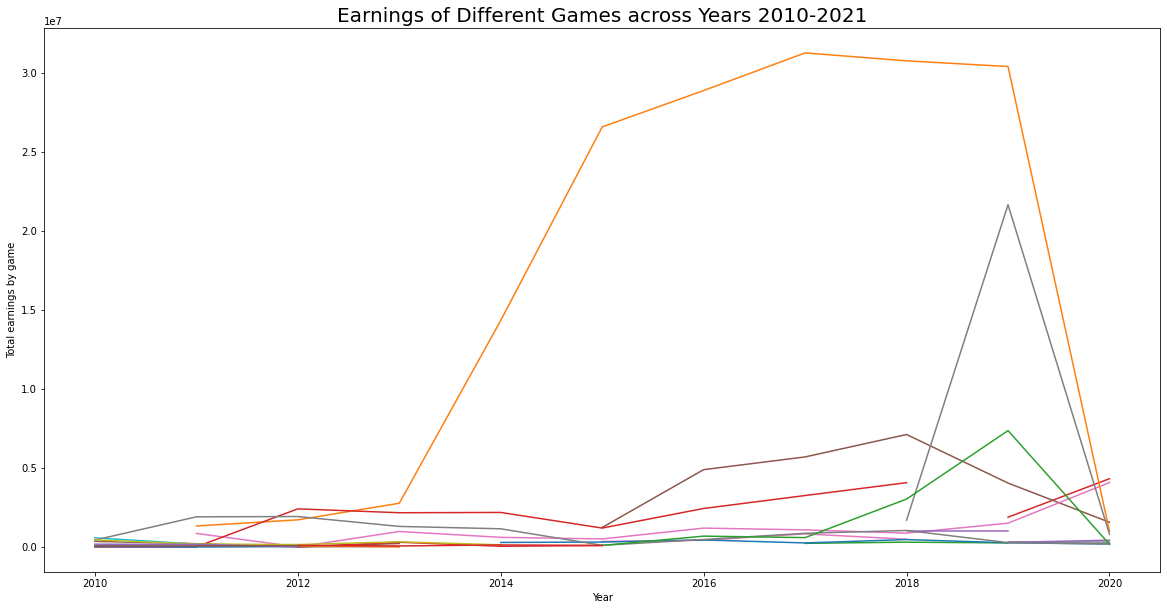

In [16]:
data = {}
plt.figure(figsize = (20,10))
plt.title("Earnings of Different Games across Years 2010-2021")
plt.xlabel("Year")
plt.ylabel("Total earnings by game")
for game in game_titles:
    r = df1[['Year','Game','Total_Year']].groupby('Game').get_group(game)
    data[game] = years_table.merge(r, how = 'left', on = ['Year'])
    plt.plot(data[game]['Year'], data[game]['Total_Year'])